In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau
import itertools

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

# Path to your data directory
data_dir = '/Users/advait/Desktop/Knee_Arthiritis_AI/data'
class_names = ["0Normal", "1Doubtful", "2Mild", "3Moderate", "4Severe"]

# Initialize lists to hold file paths and labels
file_paths = []
labels = []

# Load file paths and labels
for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for file_name in os.listdir(class_dir):
        if file_name.endswith(".png"):
            file_paths.append(os.path.join(class_dir, file_name))
            labels.append(idx)

# Convert to numpy arrays
file_paths = np.array(file_paths)
labels = np.array(labels)

# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Convert numeric labels to string class names
train_labels = [class_names[label] for label in train_labels]
val_labels = [class_names[label] for label in val_labels]

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1.0 / 255.0
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create DataFrames for train and validation data
train_df = pd.DataFrame({'filename': train_paths, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_paths, 'class': val_labels})

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)
validation_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical'
)

# Load DenseNet121 with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Build the top model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)
model_checkpoint = ModelCheckpoint('best_densenet121_model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Calculate steps per epoch based on generator batch size
steps_per_epoch = len(train_paths) // train_generator.batch_size
validation_steps = len(val_paths) // validation_generator.batch_size

# Train model without EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[reduce_lr, model_checkpoint],
    verbose=1
)

Found 1320 validated image filenames belonging to 5 classes.
Found 330 validated image filenames belonging to 5 classes.
Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-12-11 17:00:33.542104: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-12-11 17:00:45.423832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-12-11 17:00:54.249243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


165/165 ━━━━━━━━━━━━━━━━━━━━ 812s 5s/step - accuracy: 0.2665 - loss: 1.7944 - val_accuracy: 0.3963 - val_loss: 1.3692 - learning_rate: 1.0000e-04
Epoch 2/50


2024-12-11 17:13:48.819012: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-12-11 17:13:49.334689: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6277 - learning_rate: 1.0000e-04
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 589s 3s/step - accuracy: 0.3556 - loss: 1.4665 - val_accuracy: 0.4604 - val_loss: 1.2773 - learning_rate: 1.0000e-04
Epoch 4/50


2024-12-11 17:23:42.391889: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.9830 - learning_rate: 1.0000e-04
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.4222 - loss: 1.3558 - val_accuracy: 0.5274 - val_loss: 1.1999 - learning_rate: 1.0000e-04
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.2076 - learning_rate: 1.0000e-04
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4438 - loss: 1.3355
Epoch 7: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
165/165 ━━━━━━━━━━━━━━━━━━━━ 563s 3s/step - accuracy: 0.4437 - loss: 1.3353 - val_accuracy: 0.5183 - val_loss: 1.2173 - learning_rate: 1.0000e-04
Epoch 8/50


2024-12-11 17:42:47.937082: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.5327 - learning_rate: 3.0000e-05
Epoch 9/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 564s 3s/step - accuracy: 0.4646 - loss: 1.2578 - val_accuracy: 0.5274 - val_loss: 1.1613 - learning_rate: 3.0000e-05
Epoch 10/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7889 - learning_rate: 3.0000e-05
Epoch 11/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 477s 3s/step - accuracy: 0.4610 - loss: 1.2668 - val_accuracy: 0.5518 - val_loss: 1.1410 - learning_rate: 3.0000e-05
Epoch 12/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0773 - learning_rate: 3.0000e-05
Epoch 13/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4579 - loss: 1.2654
Epoch 13: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
165/165 ━━━━━━━━━━━━━━━━━━━━ 469s 3s/s

2024-12-11 18:15:39.906256: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7945 - learning_rate: 9.0000e-06
Epoch 17/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.4904 - loss: 1.2011 - val_accuracy: 0.5518 - val_loss: 1.1310 - learning_rate: 9.0000e-06
Epoch 18/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4454 - learning_rate: 9.0000e-06
Epoch 19/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 323s 2s/step - accuracy: 0.4989 - loss: 1.1885 - val_accuracy: 0.5579 - val_loss: 1.1172 - learning_rate: 9.0000e-06
Epoch 20/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.6853 - learning_rate: 9.0000e-06
Epoch 21/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.4924 - loss: 1.2178 - val_accuracy: 0.5610 - val_loss: 1.1124 - learning_rate: 9.0000e-06
Epoch 22/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 1

2024-12-11 18:55:02.744482: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


165/165 ━━━━━━━━━━━━━━━━━━━━ 128s 773ms/step - accuracy: 0.5080 - loss: 1.2047 - val_accuracy: 0.5549 - val_loss: 1.1135 - learning_rate: 1.0000e-06
Epoch 34/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.0744 - learning_rate: 1.0000e-06
Epoch 35/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 123s 744ms/step - accuracy: 0.5102 - loss: 1.1851 - val_accuracy: 0.5518 - val_loss: 1.1169 - learning_rate: 1.0000e-06
Epoch 36/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.4823 - learning_rate: 1.0000e-06
Epoch 37/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 124s 752ms/step - accuracy: 0.5140 - loss: 1.2009 - val_accuracy: 0.5579 - val_loss: 1.1123 - learning_rate: 1.0000e-06
Epoch 38/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.1770 - learning_rate: 1.0000e-06
Epoch 39/50
165/165 ━━━━━━━━━━━━━━

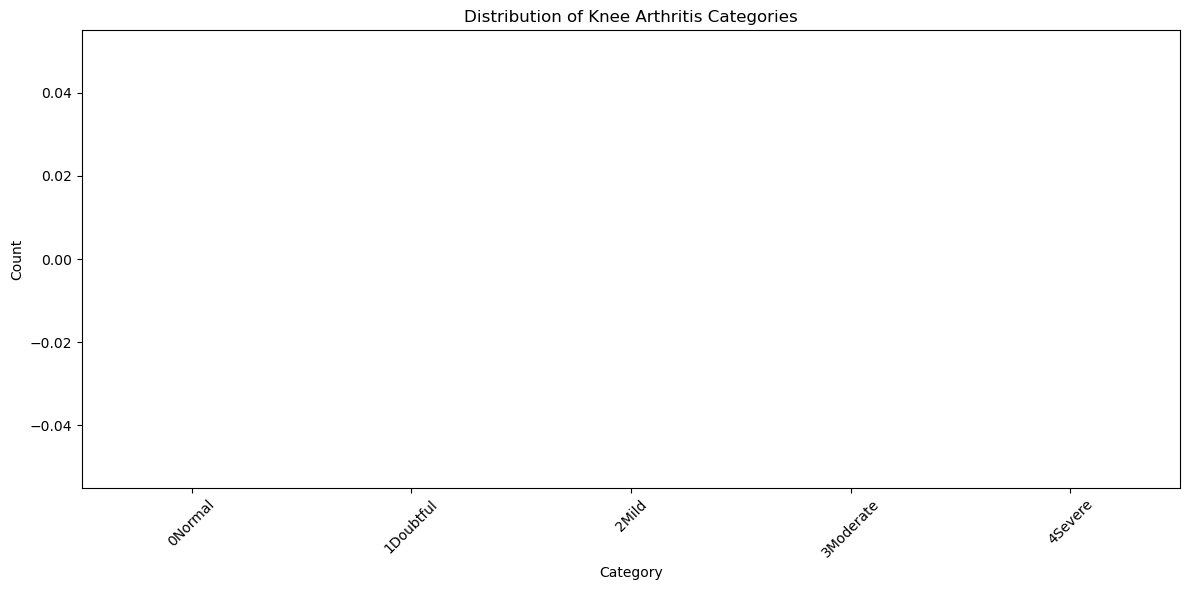

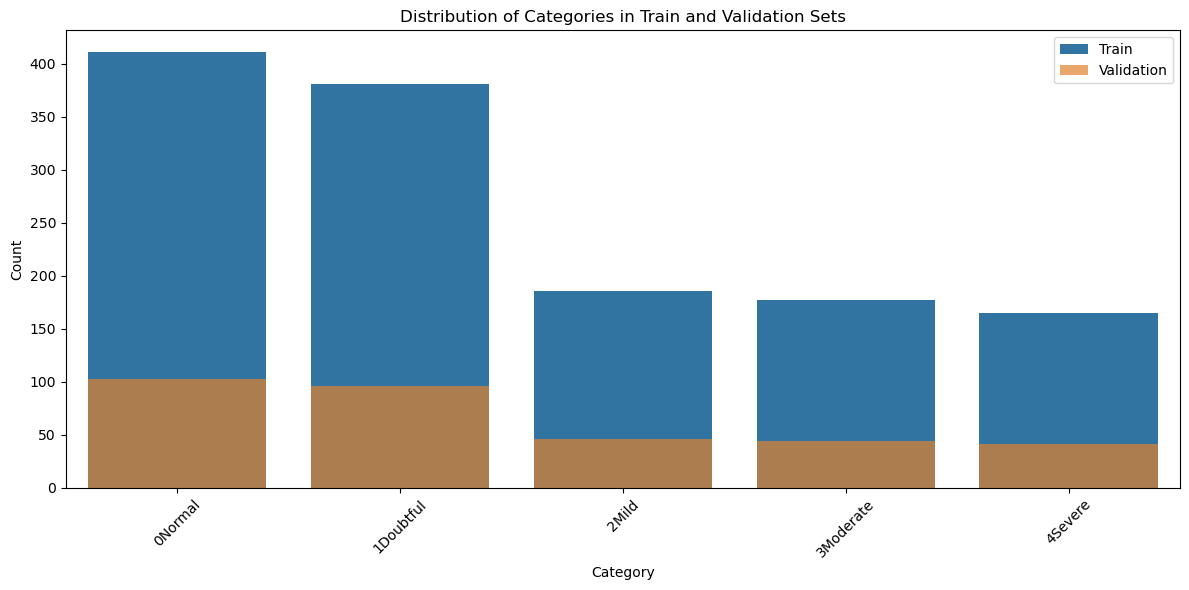

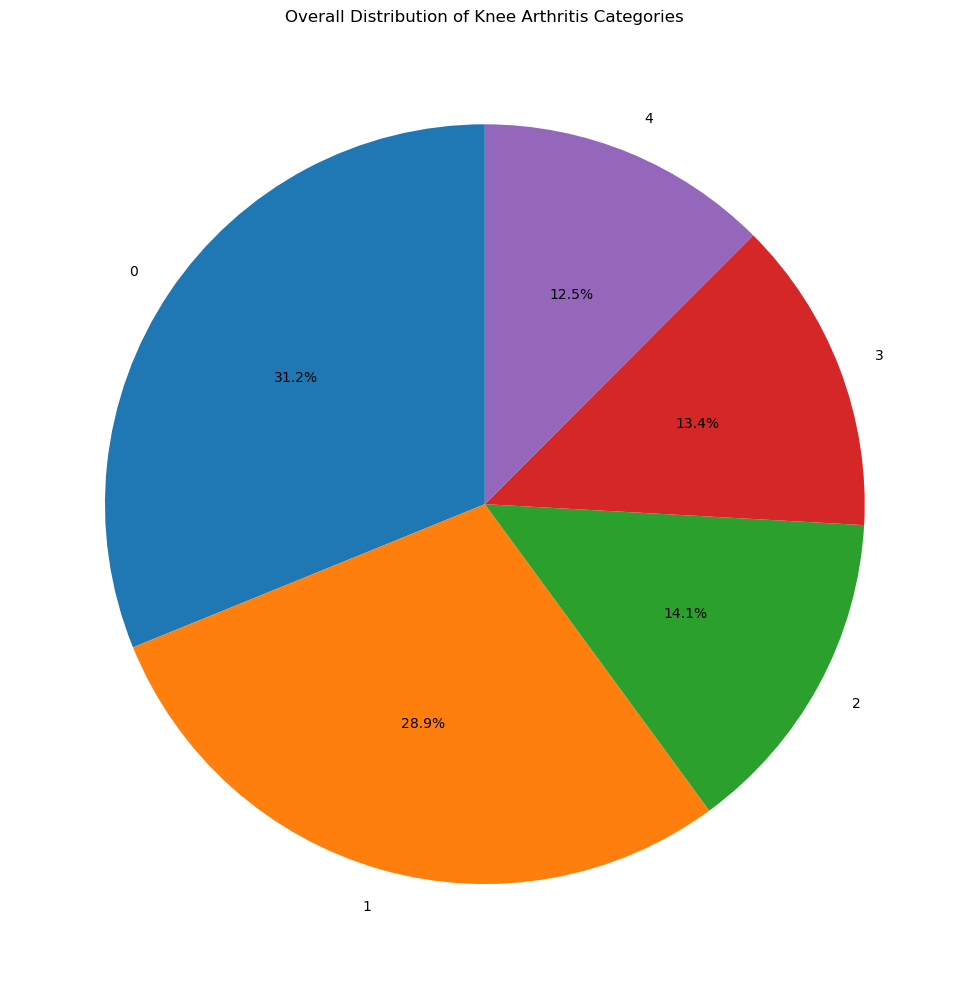

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you already have your data loaded into 'file_paths' and 'labels' lists

# Create a DataFrame
df = pd.DataFrame({'Filename': file_paths, 'Category': labels})

# Plot the distribution of categories
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Category', order=class_names)
plt.title('Distribution of Knee Arthritis Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot the distribution of categories in train and validation sets
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='class', order=class_names, label='Train')
sns.countplot(data=val_df, x='class', order=class_names, label='Validation', alpha=0.7)
plt.title('Distribution of Categories in Train and Validation Sets')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Pie chart of overall category distribution
plt.figure(figsize=(10, 10))
df['Category'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Overall Distribution of Knee Arthritis Categories')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def get_predictions(generator, model):
    generator.reset()
    y_true = []
    y_pred = []
    steps = len(generator)
    for _ in range(steps):
        x, y = next(generator)
        y_true.extend(np.argmax(y, axis=1))
        y_pred.extend(np.argmax(model.predict(x), axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for training set
y_true_train, y_pred_train = get_predictions(train_generator, model)

# Get predictions for validation set
y_true_val, y_pred_val = get_predictions(validation_generator, model)

# Generate classification report for training set
classification_report_train = classification_report(y_true_train, y_pred_train, target_names=class_names, zero_division=1)
print("Classification Report - Training Set:")
print(classification_report_train)

# Generate classification report for validation set
classification_report_val = classification_report(y_true_val, y_pred_val, target_names=class_names, zero_division=1)
print("Classification Report - Validation Set:")
print(classification_report_val)

# Save the reports to files
with open('classification_report_train.txt', 'w') as f:
    f.write("Classification Report - Training Set:\n")
    f.write(classification_report_train)

with open('classification_report_val.txt', 'w') as f:
    f.write("Classification Report - Validation Set:\n")
    f.write(classification_report_val)

# Generate and plot confusion matrices
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.close()

plot_confusion_matrix(y_true_train, y_pred_train, "Confusion Matrix - Training Set")
plot_confusion_matrix(y_true_val, y_pred_val, "Confusion Matrix - Validation Set")

# Print class distribution
print("\nClass Distribution - Training Set:")
print(np.unique(y_true_train, return_counts=True))
print("\nClass Distribution - Validation Set:")
print(np.unique(y_true_val, return_counts=True))


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2